# Cascaded Tanks Benchmark

This work will start with the cascaded tanks benchmark data set which has a variable pump deliver water to two tanks in series, using gravity to feed the water from one tank to the next.  This system has nonlinear dynamics, yet can be explained using Bernoulli's principle and the conservation of mass. A full description can be found in the `CascadedTanksFiles` folder.  The data must be downloaded from the following ZIP link from the references in the paper: (http://www.it.uu.se/research/publications/reports/2010-020/NonlinearData.zip)  

The purpose of this notebook is to model the dynamics of the system ($\frac{dh_1}{dt}$ and $\frac{dh_2}{dt}$) as functions of the current heights of the tanks and the inputs voltage to the pump.

**NOTE:** No direct units are given from the dataset for either the pump signal or the heights of the tanks.

In [6]:
# Import relevant libraries

# Data Processing
import pandas as pd
import numpy as np

# Modeling
from FoKL import FoKLRoutines

# Visualizations
import matplotlib.pyplot as plt

# Load in data
tank1 = pd.read_csv('data/tank1.csv')

## Part 1: Data Importing and Processing

The goal of the first section is to import the data into appropriate pandas data frames from their native `.mat` MATLAB files.  There are two data sets, each with different parameters. Note that the names of the files are `Tank1` and `Tank2` respectively.  The number is in reference to the dataset and the information for both tanks is available in their respective files.  Below is a list of relevant information about the datasets.

1. Dataset 1 (Named Tank1)
- Measurements taken every 5 seconds (sample rate)
- 2500 Data points (about 3.5 hours)
- Pump voltage changed every 30 samples (150 seconds)

2. Dataset 2 (Named Tank2)
- Measurements taken every 4 seconds (sample rate)
- 7500 Data points (8 hours, 20 minutes)
- Pump voltage changed every 15 samples (60 seconds)

Now that we know what data is being imported, let's being with loading it into the notebook.  For this example notebook, we will just be looking at the first dataset, but all processing can also be applied in a similar fashion to the second dataset.

An interesting point is that it seems that when the input signal to the pump changes, initially, it effects the height of tank 2 faster than tank 1 (is that correct?).  Other than that, the data is as expected.

## Part 2: Modeling
The second part is to create models (in this case, BSS-ANOVA GP's) to predict the derivatives give the current states (height of water in tanks and pump input signal).  This is fairly straight forward with the BSS-ANOVA API.  Note this uses FoKL ver. 3.3.0. Note that if you don't use the pillow, the integration will fail in Part 3.

In [7]:
# Create Models for the derivatives of h1 and h2

GP_dh1 = FoKLRoutines.FoKL(UserWarnings=False, tolerance = 1)
_ = GP_dh1.fit(inputs = [tank1[['h1','h2','u']][0:2000]], 
           data = tank1['h1_der'][0:2000], 
           clean = True,
           pillow = [[0.05,0.05],[0.05,0.05],[0,0]]) 

GP_dh2 = FoKLRoutines.FoKL(UserWarnings=False, tolerance = 1)
_ = GP_dh2.fit(inputs = [tank1[['h1','h2','u']][0:2000]], 
           data = tank1['h2_der'][0:2000], 
           clean = True,
           pillow = [[0.05,0.05],[0.05,0.05],[0,0]]) 

[1, -16973.30305786793]
[2, -17650.134943594683]
[2, -17991.466541840367]
[3, -18730.57962484938]
[3, -18869.977692873206]
[4, -19022.4397335182]
[4, -19068.472262061186]
[4, -19086.894404521336]
[5, -19085.893313080018]
[1, -18226.970445303126]
[2, -19002.50633297548]
[2, -19604.440222464502]
[3, -20205.602451581515]
[3, -20229.010539943276]
[4, -20383.366712392544]
[4, -20505.345109371763]
[4, -20523.908338684527]
[5, -20600.0461889642]
[5, -20752.211095408147]
[5, -20776.166801546333]
[6, -20793.00628044892]
[6, -20905.22685235819]
[6, -20917.00456107407]
[6, -20935.575208890787]
[7, -20985.7891547589]
[7, -20983.675604047592]


Now, as a sanity check, let's visually look at our model predictions compared to our data.

In [8]:
# Predictions based on data
tank1['h1_der_predictions'] = GP_dh1.evaluate(inputs = tank1[['h1','h2','u']], 
                                              clean = True)
tank1['h2_der_predictions'] = GP_dh2.evaluate(inputs = tank1[['h1','h2','u']], 
                                              clean = True)

Overall, it looks like our methodology is able to accurately predict the derivatives.  There are some off values at the moments where the signal to the pump is changed as these large changes are not fully able to be predicted given our inputs.  Regardless, I think we are good to move to the next step.

## Part 3: Integration of Models
The ultimate goal of this system is to be able to predict the heights of the tanks at the next time step.  So for this, we can use the initial condition and then the Gaussian Process we created in order to integrate our dynamics and find the predicted change in height of the tank and then compare with the results.

For this, we will try two methods of integration, the LSODA method implemented from the `solve_ivp` function in `scipy`, and a from scratch forward Euler solver.  First, the LSODA method.  Because this method requires an explicit ODE to integrate, we will need to do some preprocessing, such as making our input signal to the pump a continuous function since we don't have the derivative for it and creating an ODE function to integrate.  Note that for this example problem, it takes about 10 minutes to run on a normal computer.

Now, let's use the forward Euler's method (Code from Jacob Krell).

In [10]:
# Create vector of times and pump signals
tvec = tank1["time"].values
u = tank1['u'].values
# Create blank vectors for h1 and h2 values
h1 = np.zeros_like(tvec, dtype=float)
h2 = np.zeros_like(tvec, dtype=float)

# Initial Conditions
h1[0] = tank1["h1"].values[0]
h2[0] = tank1["h2"].values[0]
# Integration using forward Euler
for i in range(len(tvec) - 1):
    h1[i + 1] = h1[i] + 5 * GP_dh1.evaluate([h1[i], h2[i], u[i]], clean=True, SingleInstance=True)
    h2[i + 1] = h2[i] + 5 * GP_dh2.evaluate([h1[i], h2[i], u[i]], clean=True, SingleInstance=True)
    
    if i % 250 == 0:
        print(i)

tank1['h1_prediction'] = h1
tank1['h2_prediction'] = h2

C:\Users\Michael\AppData\Local\Temp\ipykernel_10796\732141196.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  h1[i + 1] = h1[i] + 5 * GP_dh1.evaluate([h1[i], h2[i], u[i]], clean=True, SingleInstance=True)
C:\Users\Michael\AppData\Local\Temp\ipykernel_10796\732141196.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  h2[i + 1] = h2[i] + 5 * GP_dh2.evaluate([h1[i], h2[i], u[i]], clean=True, SingleInstance=True)


0
250
500
750
1000
1250
1500
1750
2000
2250


Now, let's visualize the predictions.

In [11]:
MSE = np.sum((tank1['h2'][2000:-1] - tank1['h2_prediction'][2000:-1])**2)/len(tank1)
MSE

0.008149369008633061

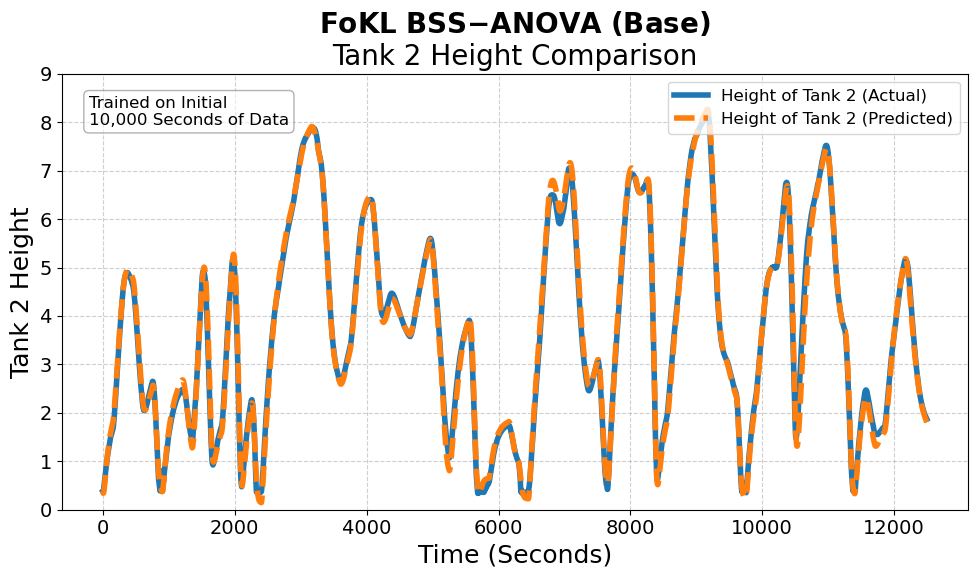

In [12]:
# Plot with improved aesthetics
plt.rcParams.update({'font.size': 14})  # Adjust the number to increase/decrease font size
fig, ax = plt.subplots(figsize=(10, 6))

# Plot both the actual and predicted data
ax.plot(tank1['time'], tank1['h2'], label='h1', linewidth=4, linestyle='-')#, color='blue')
ax.plot(tank1['time'], tank1['h2_prediction'], label='h2_prediction', linewidth=4, linestyle='--')#, color='red')

# Enhancing the graph with titles, labels, and grid
ax.set_title(r'$\bf{FoKL\ BSS{-}ANOVA\ (Base)}$' + '\nTank 2 Height Comparison', fontsize=20)
ax.set_xlabel('Time (Seconds)', fontsize=18)
ax.set_ylabel('Tank 2 Height', fontsize=18)
ax.legend(['Height of Tank 2 (Actual)', 'Height of Tank 2 (Predicted)'], fontsize=12, loc='upper right')

ax.grid(True, linestyle='--', alpha=0.6)

# ax.text(-250, 7, 'Trained on Initial \n10,000 Seconds of Data', fontsize=12, color='black', bbox = dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.4', alpha = 0.6))

# Add a note in the upper-left corner with a rounded box
ax.text(0.03, 0.95, 'Trained on Initial \n10,000 Seconds of Data',
        fontsize=12, color='black',
        bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3', alpha = 0.6),
        transform=ax.transAxes,  # Use normalized coordinates
        verticalalignment='top',  # Align text to the top of the box
        horizontalalignment='left')  # Align text to the left

ax.set_ylim(0, 9)

# Show plot
plt.tight_layout()
plt.show()

Overall, it looks like the integration methods are fairly comparable with only minor differences.